# **SETUP**

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
scaler_input = StandardScaler()
scaler_output = StandardScaler()
import os

# **LOADING DATA**

In [2]:

SteadyState_Input = []

base_path = r'C:\\Users\\ismai\\OneDrive\\Desktop\\CFD Dissertation\\Files\\CSV training\\SteadyCSV'

transient_base_path = r'C:\\Users\\ismai\\OneDrive\\Desktop\\CFD Dissertation\\Files\\CSV training\\ML_OutputLowMaxSS_CSV'

Transient_Output = []

for i in range(1, 41):  # Loop from N1 to N40
    # Construct the steady state file path
    steady_folder_name = f"N{i}Steady"
    steady_file_name = f"N{i}SSS.csv"
    steady_file_path = os.path.join(base_path, steady_folder_name, steady_file_name)
    
    # Construct the transient file path (assuming a similar naming convention)
    transient_folder_name = f"N{i}"
    transient_file_name = f"N{i}TS2.csv"
    transient_file_path = os.path.join(transient_base_path, transient_folder_name, transient_file_name)

      
    NP = pd.read_csv(steady_file_path)
    NP = NP.replace(' null', 0)
    NPSteady_velocity = NP.iloc[:, 4].values.reshape(-1, 1)
    NPSteady_velocity = scaler_input.fit_transform(NPSteady_velocity)
    SteadyState_Input.append(NPSteady_velocity)

    # Process the transient CSV
    NT = pd.read_csv(transient_file_path)
    NT = NT.replace(' null', 0)
    NPTransient_velocity = NT.iloc[:, 4].values.reshape(-1, 1)
    NPTransient_velocity = scaler_output.fit_transform(NPTransient_velocity)
    Transient_Output.append(NPTransient_velocity)

# **LSTM**

In [3]:
#https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
#https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
SteadyState_Input_LSTM = np.concatenate(SteadyState_Input) # Arrays joined into single array ith concatenate
Transient_Output_LSTM = np.concatenate(Transient_Output)  # Arrays joined into single array ith concatenate
SteadyState_Input_LSTM_Reshape = SteadyState_Input_LSTM.reshape((SteadyState_Input_LSTM.shape[0], 1, SteadyState_Input_LSTM.shape[1])) #prepare for [samples, timesteps, features]
Steady_train, Steady_test, Transient_train, Transient_test = train_test_split(SteadyState_Input_LSTM_Reshape, Transient_Output_LSTM, test_size=0.2, random_state=42) #splits the data

In [4]:
#https://keras.io/api/layers/core_layers/dense/
#https://keras.io/api/layers/recurrent_layers/lstm/#lstm-layer
#https://keras.io/guides/sequential_model/
#https://keras.io/api/optimizers/
#https://keras.io/api/losses/
#https://github.com/DPCscience/deep-learning-for-GS/blob/master/datacamp_deeplearning.py
#https://keras-contrib.readthedocs.io/en/latest/sources/getting-started/sequential-model-guide/
model = Sequential()
model.add(LSTM(32, input_shape=(Steady_train.shape[1], Steady_train.shape[2]), return_sequences=True)) #input layershape determined by the steady
model.add(LSTM(64, return_sequences=True)) #hidden layer
model.add(LSTM(64, return_sequences=True)) #hidden layer
model.add(LSTM(Transient_train.shape[1], activation='linear', return_sequences=False)) #output layer, shape determined by the transient
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']) #Loss function

In [4]:
model = Sequential()
input_features = Steady_train.shape[2]

# Define the LSTM model
model.add(LSTM(input_features, input_shape=(Steady_train.shape[1], input_features), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(Transient_train.shape[1], activation='linear', return_sequences=False))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])


In [6]:
#https://keras.io/api/layers/core_layers/dense/
#https://keras.io/api/layers/recurrent_layers/lstm/#lstm-layer
#https://keras.io/guides/sequential_model/
#https://keras.io/api/optimizers/
#https://keras.io/api/losses/
#https://github.com/DPCscience/deep-learning-for-GS/blob/master/datacamp_deeplearning.py
#https://keras-contrib.readthedocs.io/en/latest/sources/getting-started/sequential-model-guide/
#https://keras.io/api/models/model_training_apis/#evaluate-method
#https://keras.io/api/models/model_training_apis/#fit-method
model.fit(Steady_train, Transient_train, epochs=5, batch_size=16, validation_split=0.4)
loss, mse = model.evaluate(Steady_test, Transient_test)
print(f"Model performance:\nLoss: {loss}\nMSE: {mse}")

Epoch 1/5
8007/8007 [==============================] - 41s 5ms/step - loss: 0.0468 - mse: 0.0468 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 2/5
8007/8007 [==============================] - 37s 5ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 3/5
8007/8007 [==============================] - 36s 4ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 4/5
8007/8007 [==============================] - 34s 4ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 5/5
1669/1669 [==============================] - 3s 2ms/step - loss: 0.0454 - mse: 0.0454
Model performance:
Loss: 0.045378971844911575
MSE: 0.045378971844911575


# **PREDICTION**

In [7]:
# https://keras.io/api/models/model_training_apis/
SteadyState_New0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N0\N0SSS.csv')
SteadyState_New1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N41\N41SSS.csv')
SteadyState_New2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N42\N42SSS.csv')
SteadyState_New3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N43\N43SSS.csv')
SteadyState_New4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N44\N44SSS.csv')
SteadyState_New5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N45\N45SSS.csv')
SteadyState_New6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N46\N46SSS.csv')
SteadyState_New7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N47\N47SSS.csv')
SteadyState_New8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N48\N48SSS.csv')
SteadyState_New9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N49\N49SSS.csv')
SteadyState_New0 = SteadyState_New0.replace(' null', 0)
SteadyState_New1 = SteadyState_New1.replace(' null', 0)
SteadyState_New2 = SteadyState_New2.replace(' null', 0)
SteadyState_New3 = SteadyState_New3.replace(' null', 0)
SteadyState_New4 = SteadyState_New4.replace(' null', 0)
SteadyState_New5 = SteadyState_New5.replace(' null', 0)
SteadyState_New6 = SteadyState_New6.replace(' null', 0)
SteadyState_New7 = SteadyState_New7.replace(' null', 0)
SteadyState_New8 = SteadyState_New8.replace(' null', 0)
SteadyState_New9 = SteadyState_New9.replace(' null', 0)
SteadyStateVelocity_0 = SteadyState_New0.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_1 = SteadyState_New1.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_2 = SteadyState_New2.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_3 = SteadyState_New3.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_4 = SteadyState_New4.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_5 = SteadyState_New5.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_6 = SteadyState_New6.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_7 = SteadyState_New7.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_8 = SteadyState_New8.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_9 = SteadyState_New9.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_0 = scaler_input.transform(SteadyStateVelocity_0 )
SteadyStateVelocity_1 = scaler_input.transform(SteadyStateVelocity_1 )
SteadyStateVelocity_2 = scaler_input.transform(SteadyStateVelocity_2 )
SteadyStateVelocity_3 = scaler_input.transform(SteadyStateVelocity_3 )
SteadyStateVelocity_4 = scaler_input.transform(SteadyStateVelocity_4 )
SteadyStateVelocity_5 = scaler_input.transform(SteadyStateVelocity_5 )
SteadyStateVelocity_6 = scaler_input.transform(SteadyStateVelocity_6 )
SteadyStateVelocity_7 = scaler_input.transform(SteadyStateVelocity_7 )
SteadyStateVelocity_8 = scaler_input.transform(SteadyStateVelocity_8 )
SteadyStateVelocity_9 = scaler_input.transform(SteadyStateVelocity_9 )
SteadyStateVelocity_0 = SteadyStateVelocity_0.reshape((SteadyStateVelocity_0.shape[0], 1, SteadyStateVelocity_0.shape[1]))
SteadyStateVelocity_1 = SteadyStateVelocity_1.reshape((SteadyStateVelocity_1.shape[0], 1, SteadyStateVelocity_1.shape[1]))
SteadyStateVelocity_2 = SteadyStateVelocity_2.reshape((SteadyStateVelocity_2.shape[0], 1, SteadyStateVelocity_2.shape[1]))
SteadyStateVelocity_3 = SteadyStateVelocity_3.reshape((SteadyStateVelocity_3.shape[0], 1, SteadyStateVelocity_3.shape[1]))
SteadyStateVelocity_4 = SteadyStateVelocity_4.reshape((SteadyStateVelocity_4.shape[0], 1, SteadyStateVelocity_4.shape[1]))
SteadyStateVelocity_5 = SteadyStateVelocity_5.reshape((SteadyStateVelocity_5.shape[0], 1, SteadyStateVelocity_5.shape[1]))
SteadyStateVelocity_6 = SteadyStateVelocity_6.reshape((SteadyStateVelocity_6.shape[0], 1, SteadyStateVelocity_6.shape[1]))
SteadyStateVelocity_7 = SteadyStateVelocity_7.reshape((SteadyStateVelocity_7.shape[0], 1, SteadyStateVelocity_7.shape[1]))
SteadyStateVelocity_8 = SteadyStateVelocity_8.reshape((SteadyStateVelocity_8.shape[0], 1, SteadyStateVelocity_8.shape[1]))
SteadyStateVelocity_9 = SteadyStateVelocity_9.reshape((SteadyStateVelocity_9.shape[0], 1, SteadyStateVelocity_9.shape[1]))
Prediction0 = model.predict(SteadyStateVelocity_0)
Prediction1 = model.predict(SteadyStateVelocity_1)
Prediction2 = model.predict(SteadyStateVelocity_2)
Prediction3 = model.predict(SteadyStateVelocity_3)
Prediction4 = model.predict(SteadyStateVelocity_4)
Prediction5 = model.predict(SteadyStateVelocity_5)
Prediction6 = model.predict(SteadyStateVelocity_6)
Prediction7 = model.predict(SteadyStateVelocity_7)
Prediction8 = model.predict(SteadyStateVelocity_8)
Prediction9 = model.predict(SteadyStateVelocity_9)
Prediction0 = scaler_output.inverse_transform(Prediction0)
Prediction1 = scaler_output.inverse_transform(Prediction1)
Prediction2 = scaler_output.inverse_transform(Prediction2)
Prediction3 = scaler_output.inverse_transform(Prediction3)
Prediction4 = scaler_output.inverse_transform(Prediction4)
Prediction5 = scaler_output.inverse_transform(Prediction5)
Prediction6 = scaler_output.inverse_transform(Prediction6)
Prediction7 = scaler_output.inverse_transform(Prediction7)
Prediction8 = scaler_output.inverse_transform(Prediction8)
Prediction9 = scaler_output.inverse_transform(Prediction9)
SteadyState_New0 ['Transient Prediction 0'] = Prediction0
SteadyState_New1 ['Transient Prediction 1'] = Prediction1
SteadyState_New2 ['Transient Prediction 2'] = Prediction2
SteadyState_New3 ['Transient Prediction 3'] = Prediction3
SteadyState_New4 ['Transient Prediction 4'] = Prediction4
SteadyState_New5 ['Transient Prediction 5'] = Prediction5
SteadyState_New6 ['Transient Prediction 6'] = Prediction6
SteadyState_New7 ['Transient Prediction 7'] = Prediction7
SteadyState_New8 ['Transient Prediction 8'] = Prediction8
SteadyState_New9 ['Transient Prediction 9'] = Prediction9
print(Prediction0)
print(Prediction1)
print(Prediction2)
print(Prediction3)
print(Prediction4)
print(Prediction5)
print(Prediction6)
print(Prediction7)
print(Prediction8)
print(Prediction9)
SteadyState_New0.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N0PS.csv', index=False)
SteadyState_New1.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N41PS.csv', index=False)
SteadyState_New2.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N42PS.csv', index=False)
SteadyState_New3.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N43PS.csv', index=False)
SteadyState_New4.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N44PS.csv', index=False)
SteadyState_New5.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N45PS.csv', index=False)
SteadyState_New6.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N46PS.csv', index=False)
SteadyState_New7.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N47PS.csv', index=False)
SteadyState_New8.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N48PS.csv', index=False)
SteadyState_New9.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N49PS.csv', index=False)

30/30 [==============================] - 0s 2ms/step
[[0.08796281]
 [0.08490309]
 [0.0840694 ]
 ...
 [0.20259479]
 [0.05586782]
 [0.18961439]]
[[2.670566  ]
 [2.4852078 ]
 [2.2136245 ]
 [0.77620894]
 [0.50618804]
 [0.6530938 ]
 [2.2878997 ]
 [2.4291382 ]
 [2.6921692 ]
 [1.5328646 ]
 [1.1401407 ]
 [0.94628286]
 [1.7956331 ]
 [1.9550147 ]
 [2.2564416 ]
 [2.5633047 ]
 [2.5209239 ]
 [2.6490002 ]
 [2.8435183 ]
 [2.8003643 ]
 [2.0587034 ]
 [2.6060197 ]
 [0.5496855 ]
 [0.38359755]
 [0.49381107]
 [0.46912843]
 [2.5846245 ]
 [2.3739424 ]
 [2.627481  ]
 [1.4341705 ]
 [1.1701369 ]
 [1.3270649 ]
 [0.9712685 ]
 [0.9587861 ]
 [1.3242451 ]
 [1.4816364 ]
 [0.659391  ]
 [0.60595995]
 [1.9511217 ]
 [1.7998488 ]
 [2.1981661 ]
 [0.6877594 ]
 [0.81412905]
 [2.2878997 ]
 [2.4518797 ]
 [0.3805697 ]
 [0.83623224]
 [0.9837294 ]
 [2.4831164 ]
 [1.0302439 ]
 [1.1068591 ]
 [1.1939424 ]
 [0.7825302 ]
 [0.89295286]
 [1.164158  ]
 [1.550416  ]
 [1.0518206 ]
 [1.2351635 ]
 [0.58403337]
 [2.2039568 ]
 [2.7570946 ]
 [2

# **RESULT N0**

In [3]:
PredictedTransient0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N0PS.csv')
# Print column names
print(PredictedTransient0.columns)
PredictedTransient0 = PredictedTransient0.replace(' null', np.nan)
x = PredictedTransient0[' X [ m ]']
y = PredictedTransient0[' Y [ m ]']
ste_velocity = PredictedTransient0[' Wall Shear [ Pa ]']
velocity = PredictedTransient0['Transient Prediction 0']
diff_ste = PredictedTransient0['Transient Prediction 0'] - PredictedTransient0[' Wall Shear [ Pa ]']
CFDTransient0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N0tlow\N0TS2.csv')
print(CFDTransient0.columns)
CFDTransient0 = CFDTransient0.replace(' null', np.nan)
x = CFDTransient0 [' X [ m ]']
y = CFDTransient0 [' Y [ m ]']
velocity_truth = CFDTransient0 [' Wall Shear [ Pa ]']
diff_vel = PredictedTransient0['Transient Prediction 0'] - CFDTransient0[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 0'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


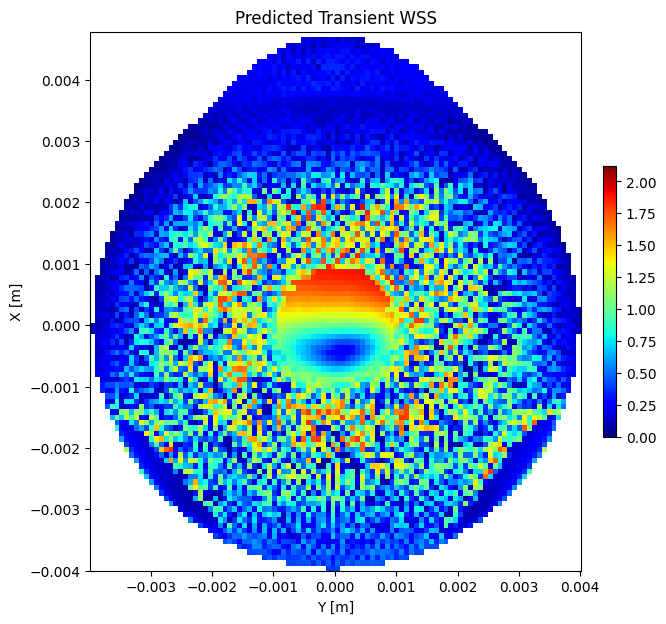

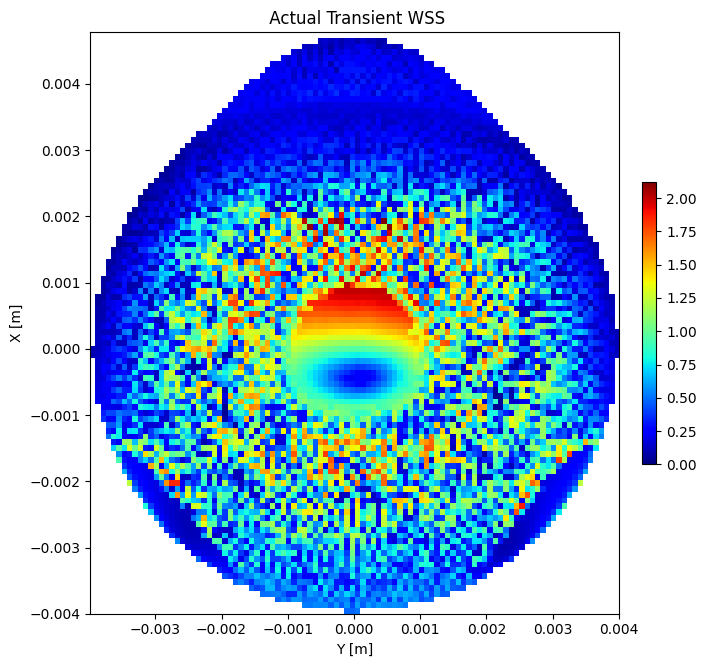

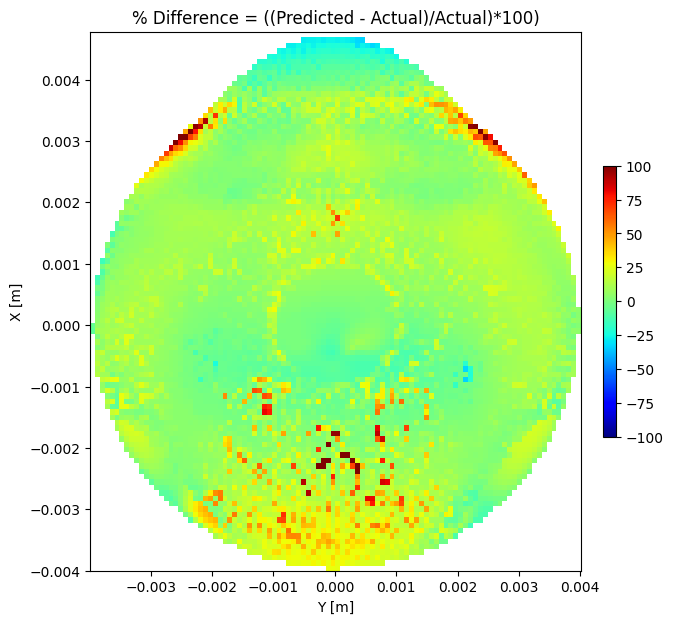

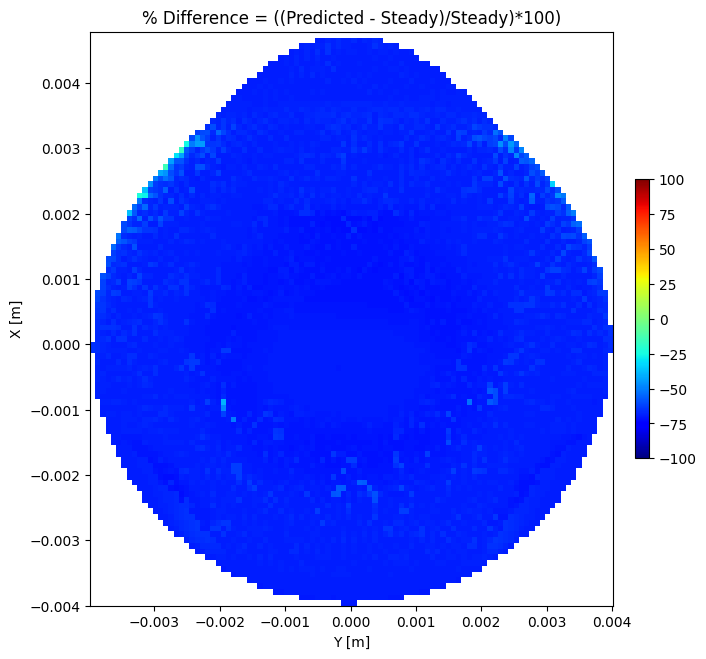

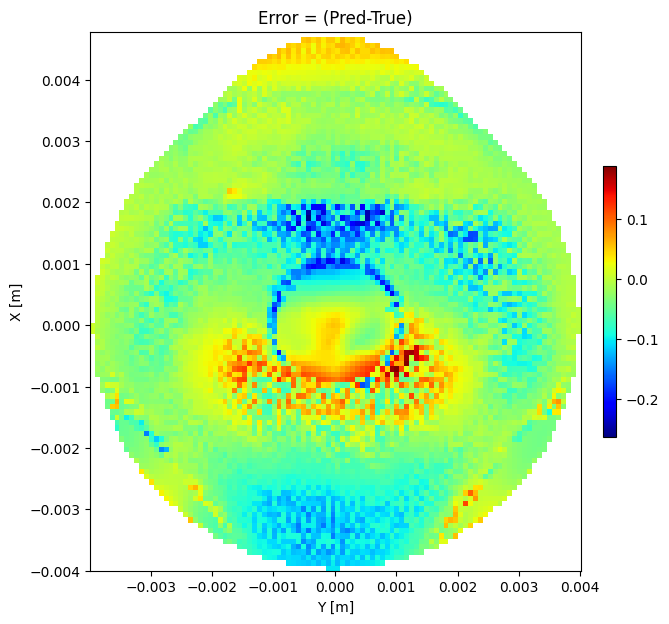

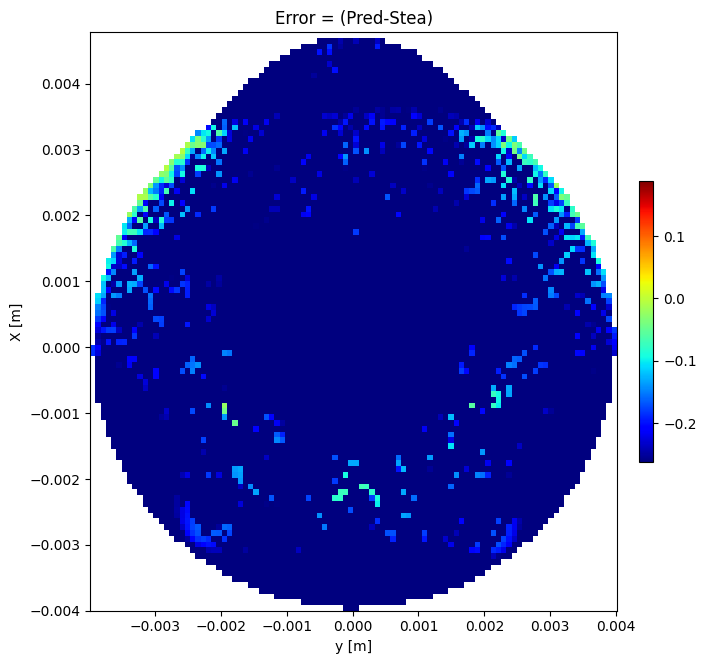

In [4]:
# Generate your grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j] #Interpolation of data onto a grid:

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, y), ste_velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values
# masked array where 'nan' values, 0 velocity values, and velocity values 0.001 or less are masked

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(y), max(y), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1,fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("Y [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(y), max(y), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2,fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient WSS')
ax2.set_xlabel("Y [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(y), max(y), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Predicted - Actual)/Actual)*100)')
ax3.set_xlabel("Y [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(y), max(y), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Predicted - Steady)/Steady)*100)')
ax4.set_xlabel("Y [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(y), max(y), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Y [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(y), max(y), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("y [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

In [5]:
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3/100, average_percentage_change4

(0.10974734384492672, 68.62099706612271)

In [6]:
max_shear = np.max(Prediction0)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient0[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction0)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient0[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient0[' Wall Shear [ Pa ]'], Prediction0)
print(r2)

NameError: name 'Prediction0' is not defined

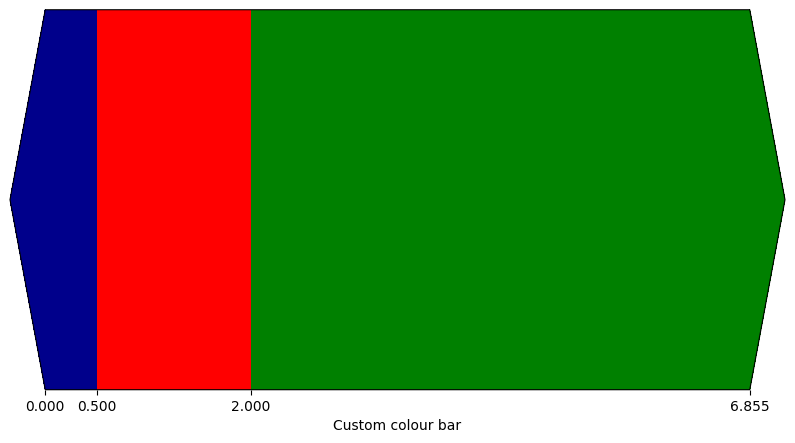

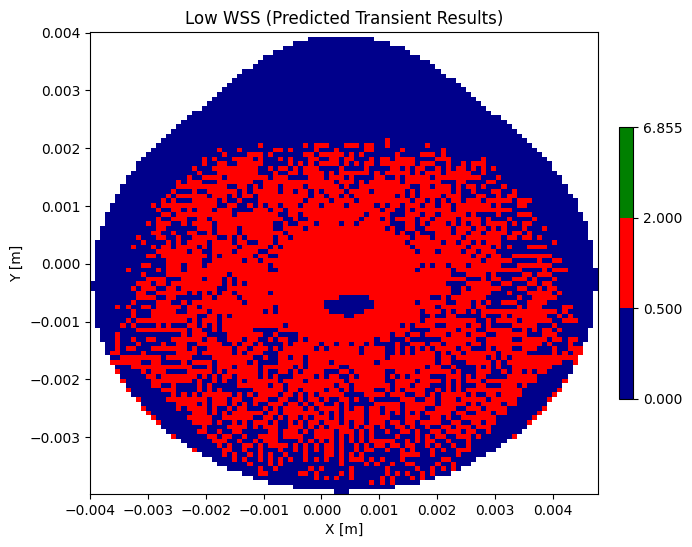

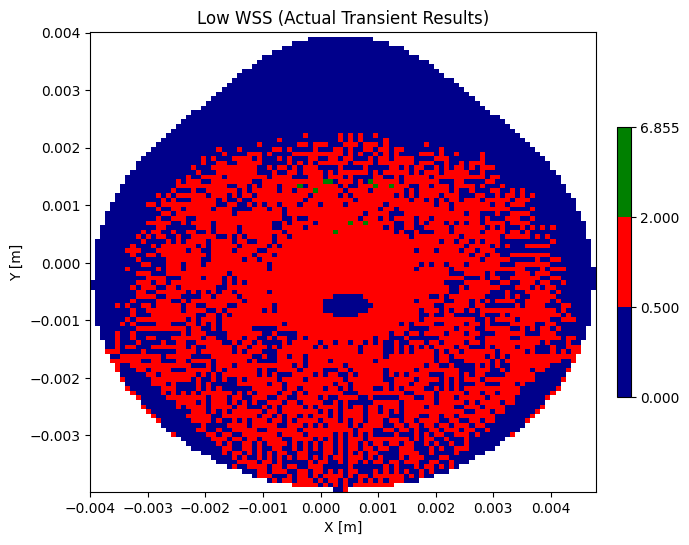

In [7]:
import matplotlib as mpl
# Generate your grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolate the velocity onto the grid
grid_WSS0 = griddata((x, y), ste_velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste, (grid_x, grid_y), method='linear', fill_value=np.nan)

max_value = np.nanmax([grid_WSS0])

colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(10, 10))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)
#cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Rotate the data
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)
rotated_masked_WSS3 = np.rot90(masked_WSS3, 1)
rotated_masked_WSS4 = np.rot90(masked_WSS4, 1)

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')
im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, fraction=0.025, pad=0.04)
ax1.set_title('Low WSS (Predicted Transient Results)')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

fig, (ax2) = plt.subplots(1, figsize=(7, 7))
im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, fraction=0.025, pad=0.04)
ax2.set_title('Low WSS (Actual Transient Results)')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")
plt.tight_layout()
plt.show()

# **RESULT N41**

In [14]:
PredictedTransient1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N41PS.csv')
# Print column names
print(PredictedTransient1.columns)
PredictedTransient1 = PredictedTransient1.fillna(0)
PredictedTransient1 = PredictedTransient1.replace(' null', np.nan)
x = PredictedTransient1[' X [ m ]']
y = PredictedTransient1[' Y [ m ]']
ste_velocity1 = PredictedTransient1[' Wall Shear [ Pa ]']
velocity1 = PredictedTransient1['Transient Prediction 1']
diff_ste1 = PredictedTransient1['Transient Prediction 1'] - PredictedTransient1[' Wall Shear [ Pa ]']
CFDTransient1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N41Tlow\N41TS2.csv')
print(CFDTransient1.columns)
CFDTransient1 = CFDTransient1.fillna(0)
CFDTransient1 = CFDTransient1.replace(' null', np.nan)
x = CFDTransient1 [' X [ m ]']
y = CFDTransient1 [' Y [ m ]']
velocity_truth1 = CFDTransient1 [' Wall Shear [ Pa ]']
diff_vel1 = PredictedTransient1['Transient Prediction 1'] - CFDTransient1[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 1'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


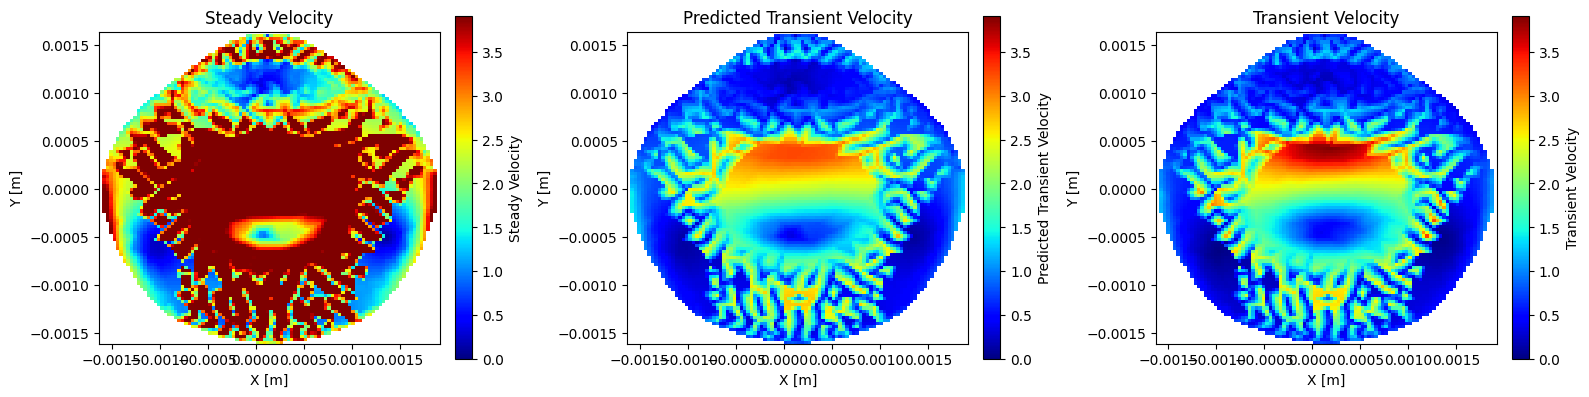

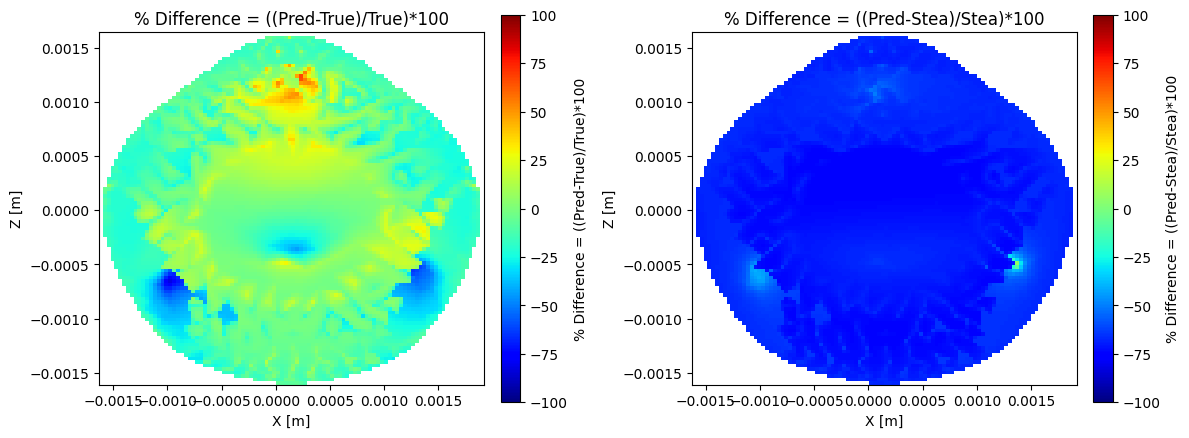

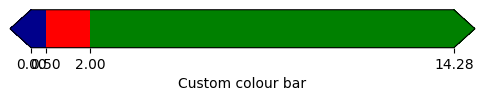

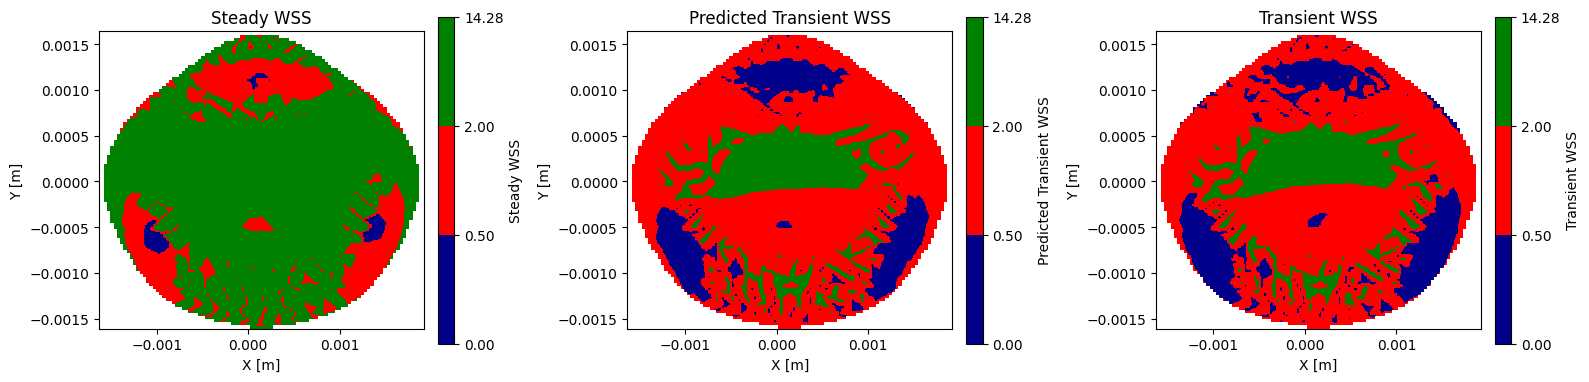

In [15]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste1, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste1, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

In [16]:
max_shear = np.max(Prediction1)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient1[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction1)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient1[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient1[' Wall Shear [ Pa ]'], Prediction1)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

Maximum shear from the prediction is: 3.2653920650482178
Maximum shear from the actual is: 3.94
Min shear from the prediction is: 0.0938987135887146
Min shear from the actual is: 0.0197
% is: 17.122028805882795
0.9558493945596085


(12.912423707330882, 69.35045089071825)

# **RESULT N42**

In [18]:
PredictedTransient2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N42PS.csv')
# Print column names
print(PredictedTransient2.columns)
PredictedTransient2 = PredictedTransient2.fillna(0)
PredictedTransient2 = PredictedTransient2.replace(' null', np.nan)
x = PredictedTransient2[' X [ m ]']
y = PredictedTransient2[' Y [ m ]']
ste_velocity2 = PredictedTransient2[' Wall Shear [ Pa ]']
velocity2 = PredictedTransient2['Transient Prediction 2']
diff_ste2 = PredictedTransient2['Transient Prediction 2'] - PredictedTransient2[' Wall Shear [ Pa ]']
CFDTransient2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N42Tlow\N42TS2.csv')
print(CFDTransient2.columns)
CFDTransient2 = CFDTransient2.fillna(0)
CFDTransient2 = CFDTransient2.replace(' null', np.nan)
x = CFDTransient2 [' X [ m ]']
y = CFDTransient2 [' Y [ m ]']
velocity_truth2 = CFDTransient2 [' Wall Shear [ Pa ]']
diff_vel2 = PredictedTransient2['Transient Prediction 2'] - CFDTransient2[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 2'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


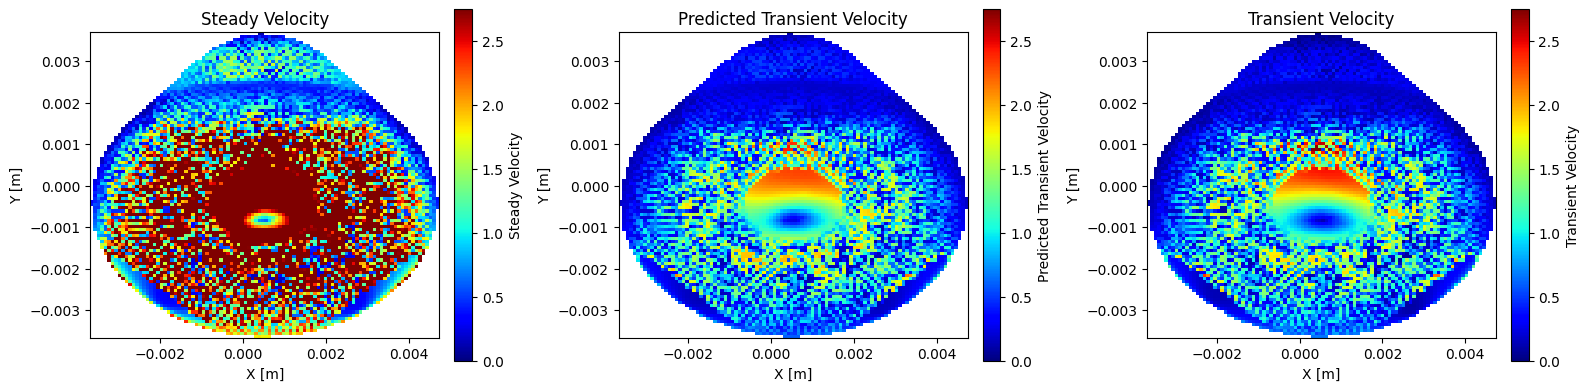

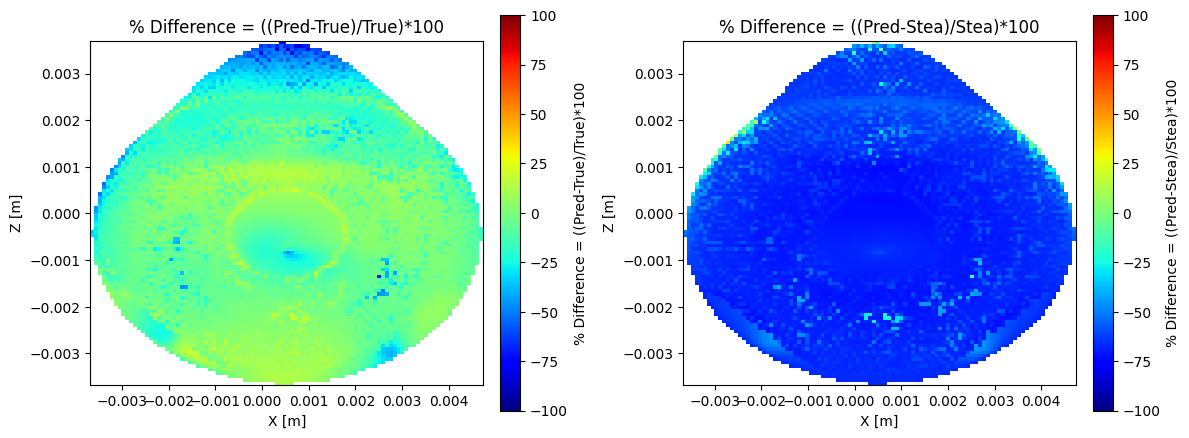

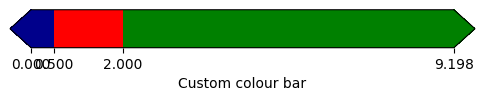

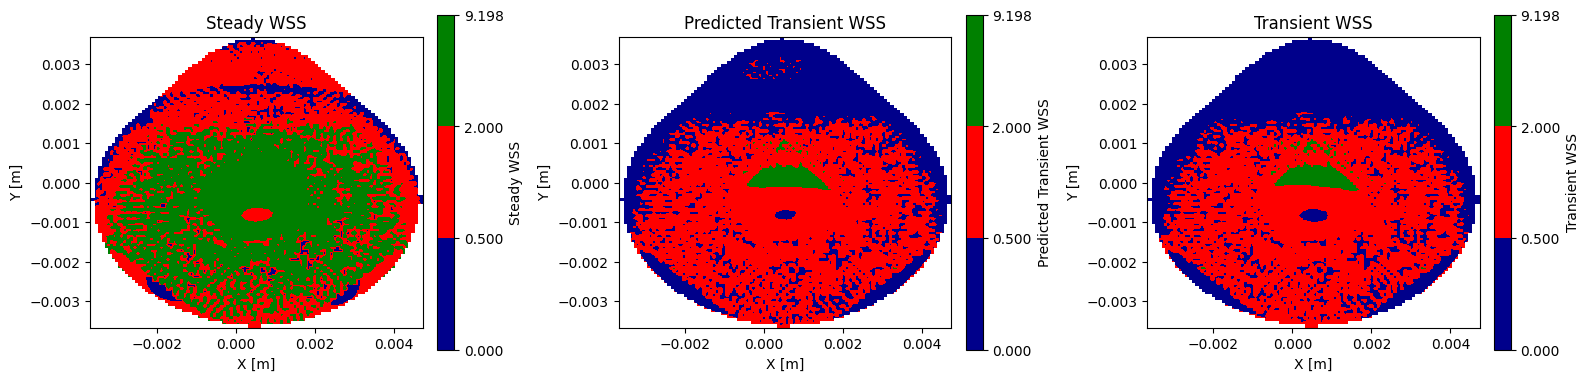

In [19]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste2, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste2, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

In [20]:
max_shear = np.max(Prediction2)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient2[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction2)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient2[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient2[' Wall Shear [ Pa ]'], Prediction2)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

Maximum shear from the prediction is: 2.46185040473938
Maximum shear from the actual is: 2.75
Min shear from the prediction is: 0.08564743399620056
Min shear from the actual is: 0.00378
% is: 10.478167100386186
0.9870975114546835


(10.072371617113527, 64.89539605086183)

# **RESULT N43**

In [21]:
PredictedTransient3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N43PS.csv')
# Print column names
print(PredictedTransient3.columns)
PredictedTransient3 = PredictedTransient3.fillna(0)
PredictedTransient3 = PredictedTransient3.replace(' null', np.nan)
x = PredictedTransient3[' X [ m ]']
y = PredictedTransient3[' Y [ m ]']
ste_velocity3 = PredictedTransient3[' Wall Shear [ Pa ]']
velocity3 = PredictedTransient3['Transient Prediction 3']
diff_ste3 = PredictedTransient3['Transient Prediction 3'] - PredictedTransient3[' Wall Shear [ Pa ]']
CFDTransient3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N43Tlow\N43TS2.csv')
print(CFDTransient3.columns)
CFDTransient3 = CFDTransient3.fillna(0)
CFDTransient3 = CFDTransient3.replace(' null', np.nan)
x = CFDTransient3 [' X [ m ]']
y = CFDTransient3 [' Y [ m ]']
velocity_truth3 = CFDTransient3 [' Wall Shear [ Pa ]']
diff_vel3 = PredictedTransient3['Transient Prediction 3'] - CFDTransient3[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 3'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


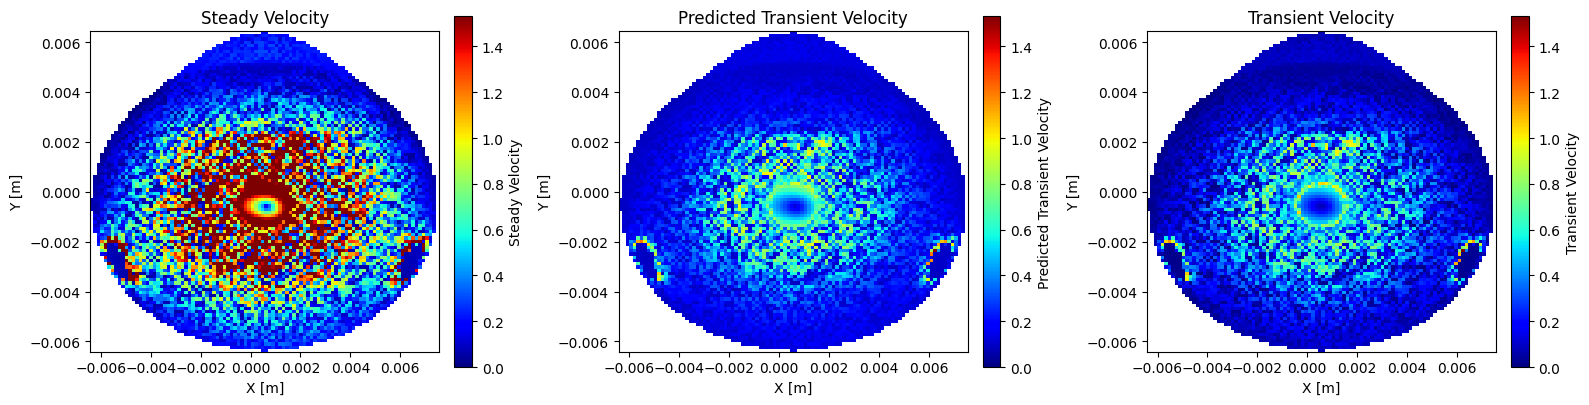

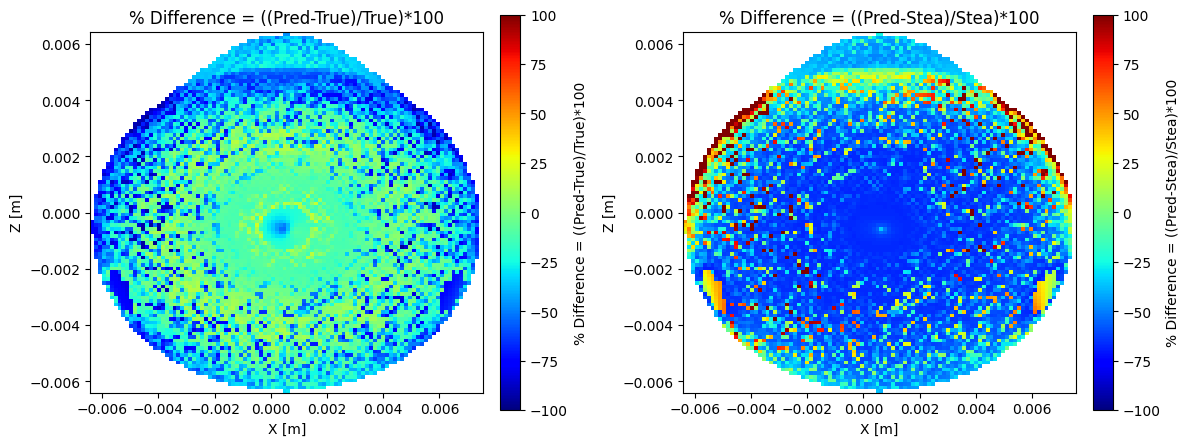

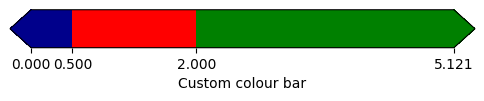

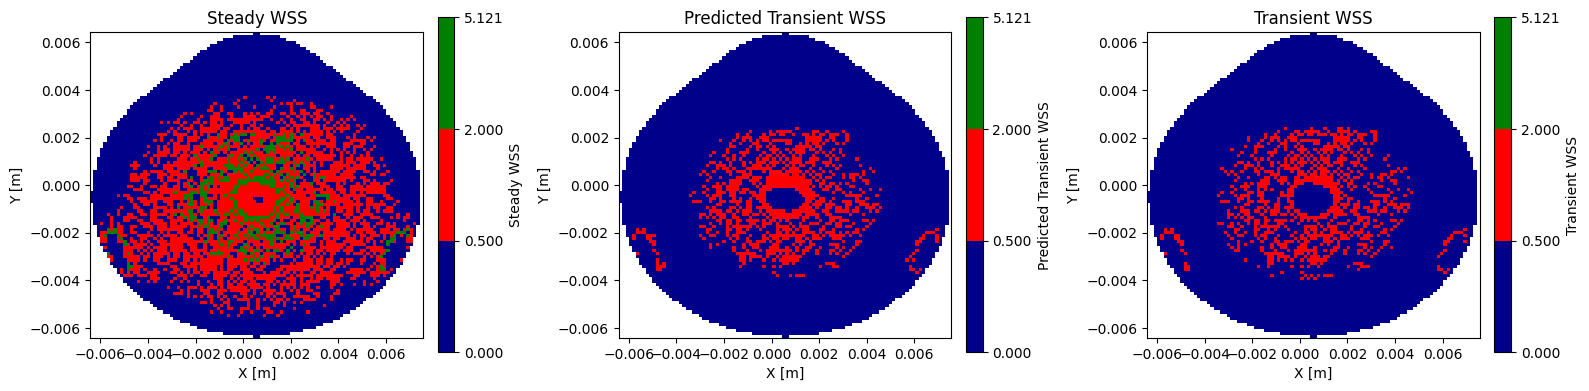

Maximum shear from the prediction is: 2.1269888877868652
Maximum shear from the actual is: 2.12
Min shear from the prediction is: 0.07855179905891418
Min shear from the actual is: 0.0006
% is: 0.3296645182483551
0.9345038597910457


(28.19692847589827, 54.8368107081694)

In [22]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste3, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste3, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction3)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient3[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction3)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient3[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient3[' Wall Shear [ Pa ]'], Prediction3)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N44**

In [23]:
PredictedTransient4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N44PS.csv')
# Print column names
print(PredictedTransient4.columns)
PredictedTransient4 = PredictedTransient4.fillna(0)
PredictedTransient4 = PredictedTransient4.replace(' null', np.nan)
x = PredictedTransient4[' X [ m ]']
y = PredictedTransient4[' Y [ m ]']
ste_velocity4 = PredictedTransient4[' Wall Shear [ Pa ]']
velocity4 = PredictedTransient4['Transient Prediction 4']
diff_ste4 = PredictedTransient4['Transient Prediction 4'] - PredictedTransient4[' Wall Shear [ Pa ]']
CFDTransient4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N44Tlow\N44TS2.csv')
print(CFDTransient4.columns)
CFDTransient4 = CFDTransient4.fillna(0)
CFDTransient4 = CFDTransient4.replace(' null', np.nan)
x = CFDTransient4 [' X [ m ]']
y = CFDTransient4 [' Y [ m ]']
velocity_truth4 = CFDTransient4 [' Wall Shear [ Pa ]']
diff_vel4 = PredictedTransient4 ['Transient Prediction 4'] - CFDTransient4[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 4'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


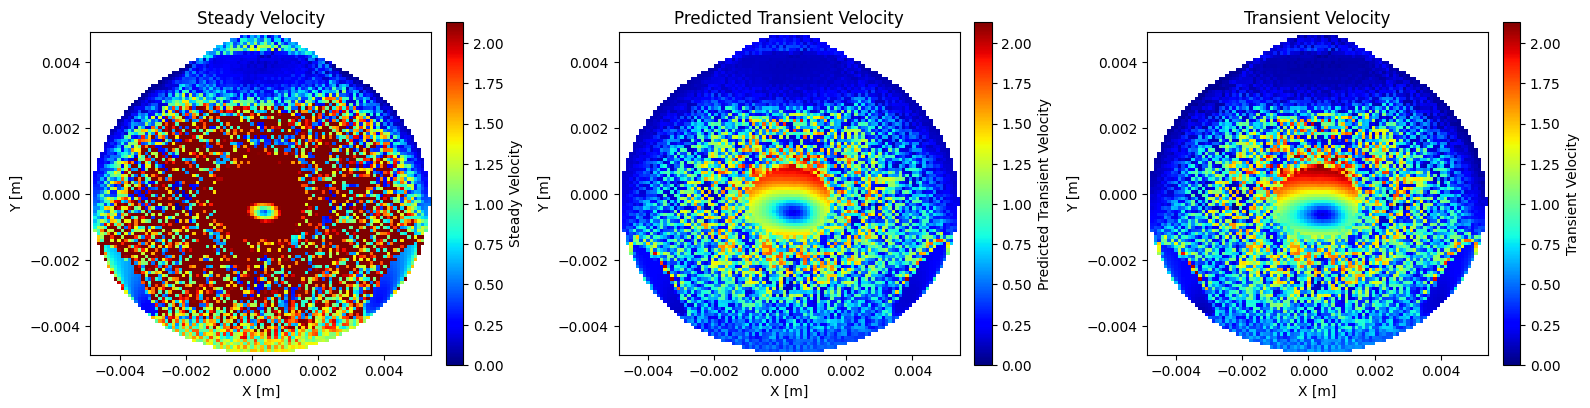

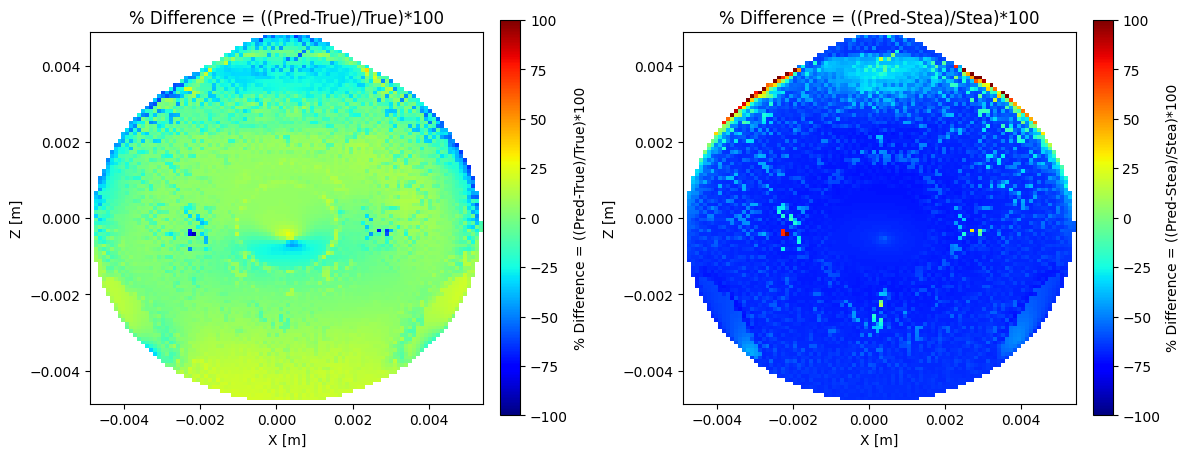

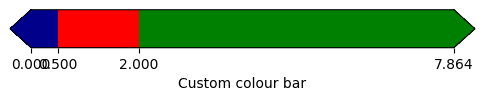

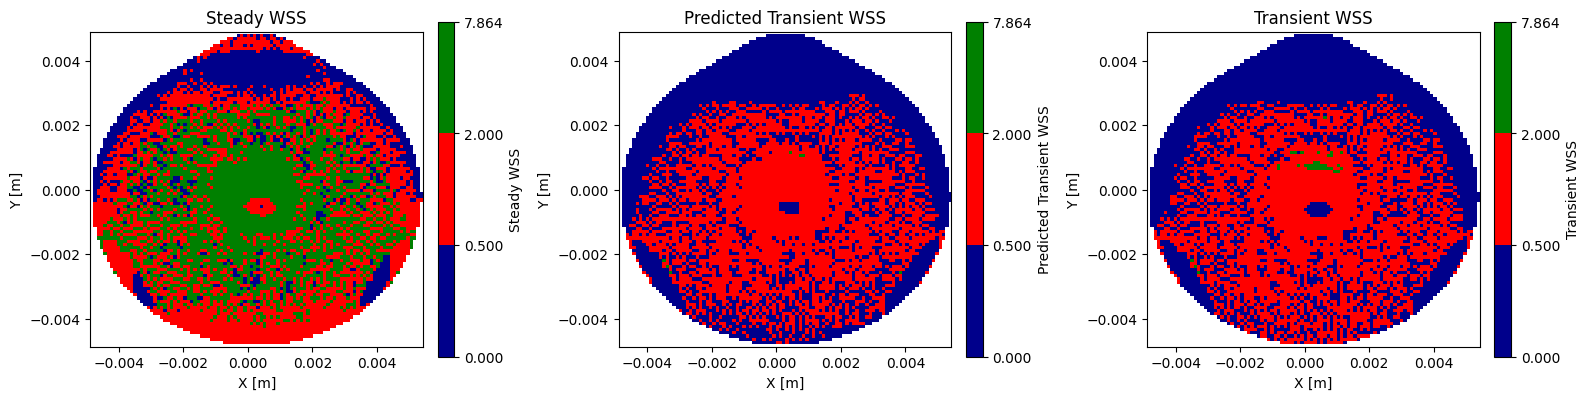

Maximum shear from the prediction is: 2.3617045879364014
Maximum shear from the actual is: 2.31
Min shear from the prediction is: 0.07911071181297302
Min shear from the actual is: 0.00778
% is: 2.2382938500606633
0.9859234023520498


(10.007533318043228, 62.31226209506153)

In [24]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste4, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste4, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction4)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient4[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction4)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient4[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient4[' Wall Shear [ Pa ]'], Prediction4)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N45**

In [25]:
PredictedTransient5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N45PS.csv')
# Print column names
print(PredictedTransient5.columns)
PredictedTransient5 = PredictedTransient5.fillna(0)
PredictedTransient5 = PredictedTransient5.replace(' null', np.nan)
x = PredictedTransient5[' X [ m ]']
y = PredictedTransient5[' Y [ m ]']
ste_velocity5 = PredictedTransient5[' Wall Shear [ Pa ]']
velocity5 = PredictedTransient5['Transient Prediction 5']
diff_ste5 = PredictedTransient5['Transient Prediction 5'] - PredictedTransient5[' Wall Shear [ Pa ]']
CFDTransient5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N45Tlow\N45TS2.csv')
print(CFDTransient5.columns)
CFDTransient5 = CFDTransient5.fillna(0)
CFDTransient5 = CFDTransient5.replace(' null', np.nan)
x = CFDTransient5 [' X [ m ]']
y = CFDTransient5 [' Y [ m ]']
velocity_truth5 = CFDTransient5 [' Wall Shear [ Pa ]']
diff_vel5 = PredictedTransient5 ['Transient Prediction 5'] - CFDTransient5[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 5'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


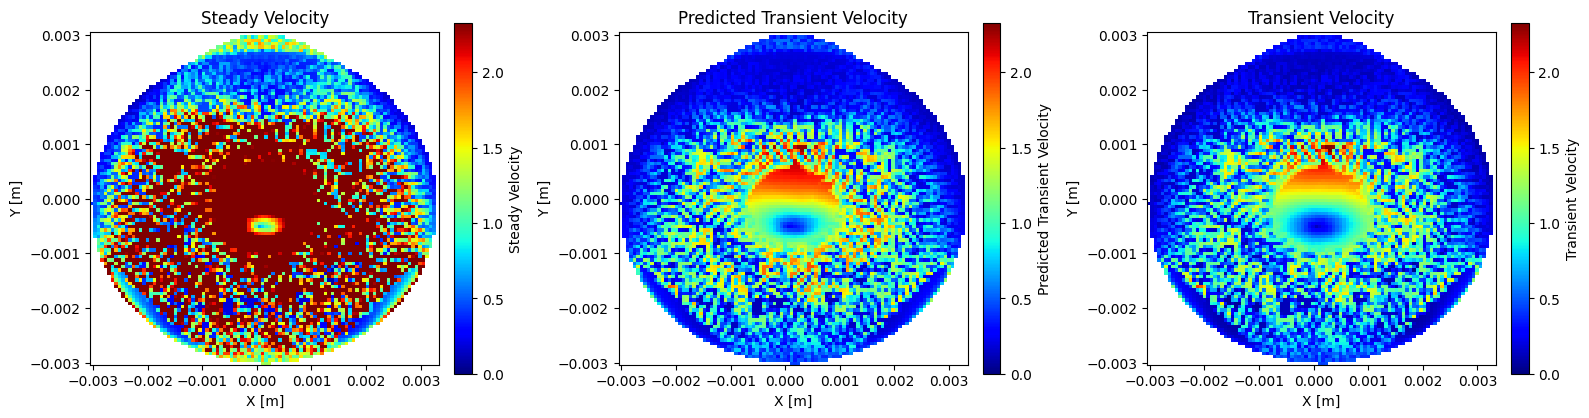

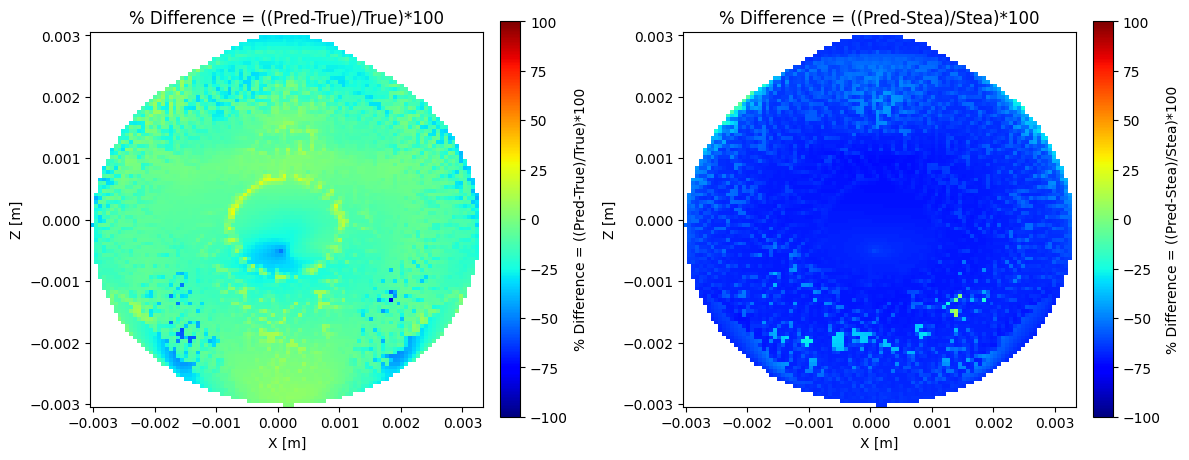

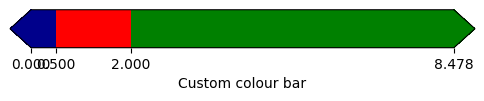

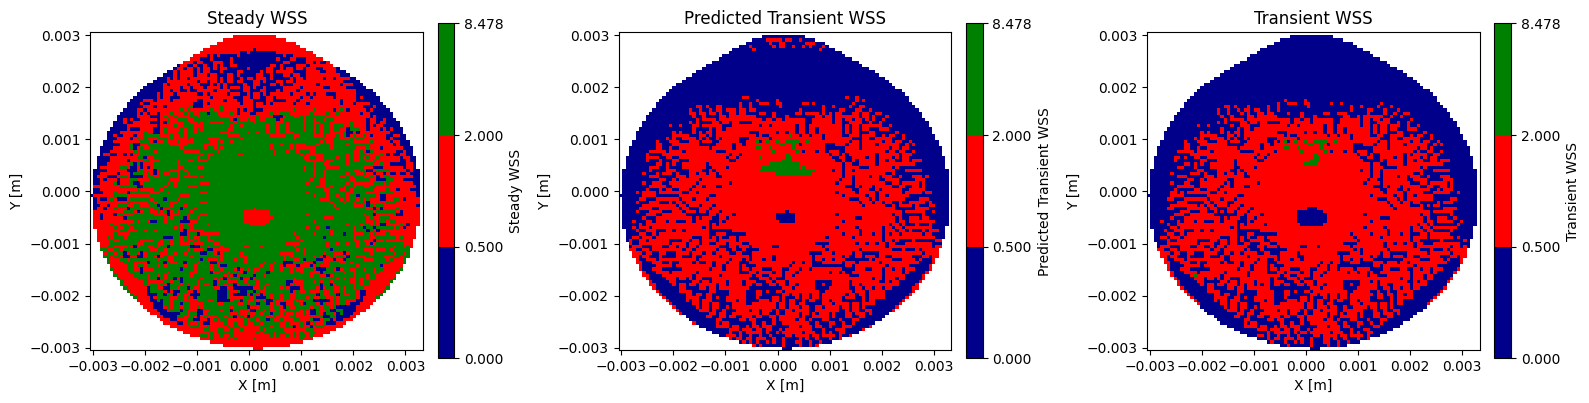

Maximum shear from the prediction is: 2.317106008529663
Maximum shear from the actual is: 2.38
Min shear from the prediction is: 0.0854024589061737
Min shear from the actual is: 0.00757
% is: 2.642604683627597
0.9663880249689485


(12.399662644351446, 64.3540087991968)

In [26]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste5, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste5, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction5)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient5[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction5)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient5[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient5[' Wall Shear [ Pa ]'], Prediction5)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N46**

In [27]:
PredictedTransient6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N46PS.csv')
# Print column names
print(PredictedTransient6.columns)
PredictedTransient6 = PredictedTransient6.fillna(0)
PredictedTransient6 = PredictedTransient6.replace(' null', np.nan)
x = PredictedTransient6[' X [ m ]']
y = PredictedTransient6[' Y [ m ]']
ste_velocity6 = PredictedTransient6[' Wall Shear [ Pa ]']
velocity6 = PredictedTransient6['Transient Prediction 6']
diff_ste6 = PredictedTransient6['Transient Prediction 6'] - PredictedTransient6[' Wall Shear [ Pa ]']
CFDTransient6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N46Tlow\N46TS2.csv')
print(CFDTransient6.columns)
CFDTransient6 = CFDTransient6.fillna(0)
CFDTransient6 = CFDTransient6.replace(' null', np.nan)
x = CFDTransient6 [' X [ m ]']
y = CFDTransient6 [' Y [ m ]']
velocity_truth6 = CFDTransient6 [' Wall Shear [ Pa ]']
diff_vel6 = PredictedTransient6 ['Transient Prediction 6'] - CFDTransient6[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 6'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


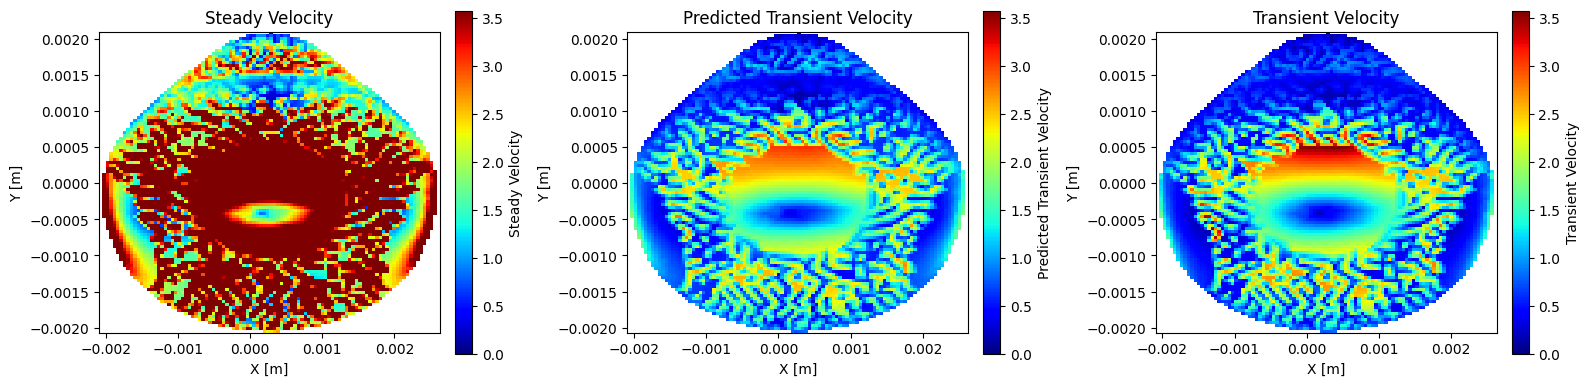

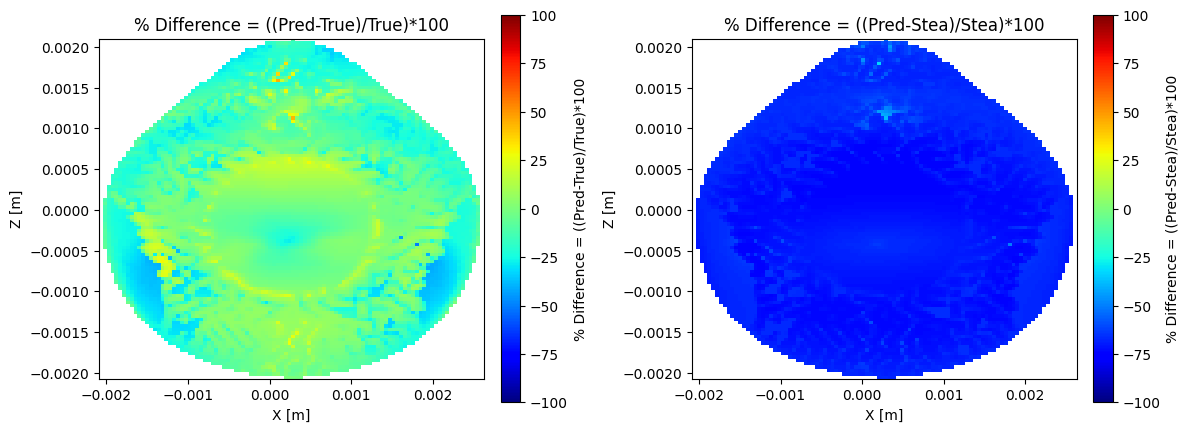

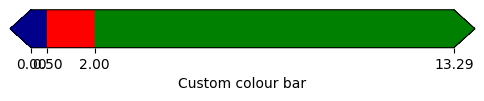

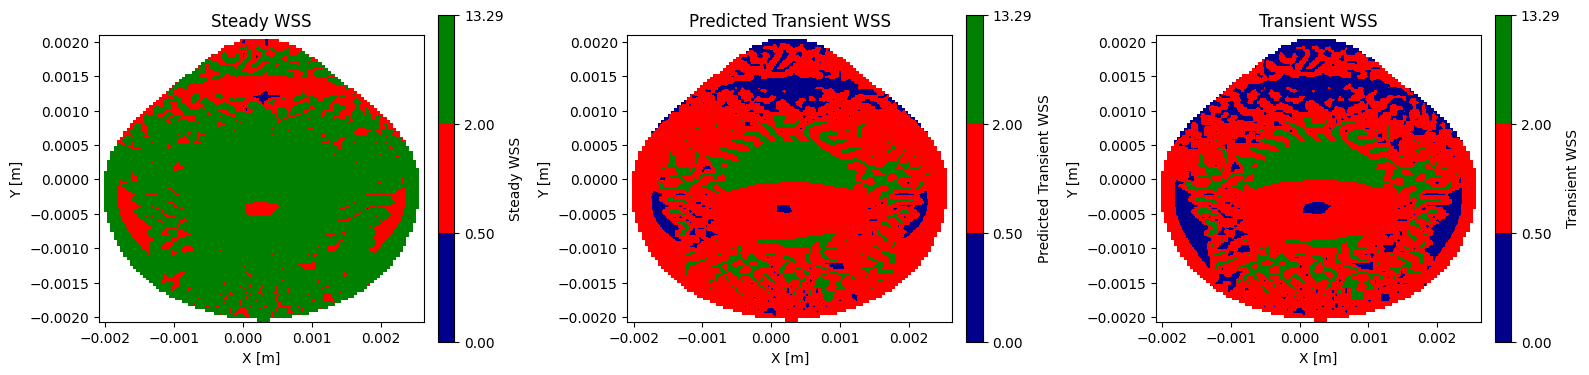

Maximum shear from the prediction is: 3.237110137939453
Maximum shear from the actual is: 4.0
Min shear from the prediction is: 0.08349362015724182
Min shear from the actual is: 0.0211
% is: 19.072246551513672
0.9654168137612529


(11.530941196030204, 69.80172115346573)

In [28]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste6, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste6, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction6)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient6[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction6)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient6[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient6[' Wall Shear [ Pa ]'], Prediction6)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N47** 

In [29]:
PredictedTransient7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N47PS.csv')
# Print column names
print(PredictedTransient7.columns)
PredictedTransient7 = PredictedTransient7.fillna(0)
PredictedTransient7 = PredictedTransient7.replace(' null', np.nan)
x = PredictedTransient7[' X [ m ]']
y = PredictedTransient7[' Y [ m ]']
ste_velocity7 = PredictedTransient7[' Wall Shear [ Pa ]']
velocity7 = PredictedTransient7['Transient Prediction 7']
diff_ste7 = PredictedTransient7['Transient Prediction 7'] - PredictedTransient7[' Wall Shear [ Pa ]']
CFDTransient7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N47Tlow\N47TS2.csv')
print(CFDTransient7.columns)
CFDTransient7 = CFDTransient7.fillna(0)
CFDTransient7 = CFDTransient7.replace(' null', np.nan)
x = CFDTransient7 [' X [ m ]']
y = CFDTransient7 [' Y [ m ]']
velocity_truth7 = CFDTransient7 [' Wall Shear [ Pa ]']
diff_vel7 = PredictedTransient7 ['Transient Prediction 7'] - CFDTransient7[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 7'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


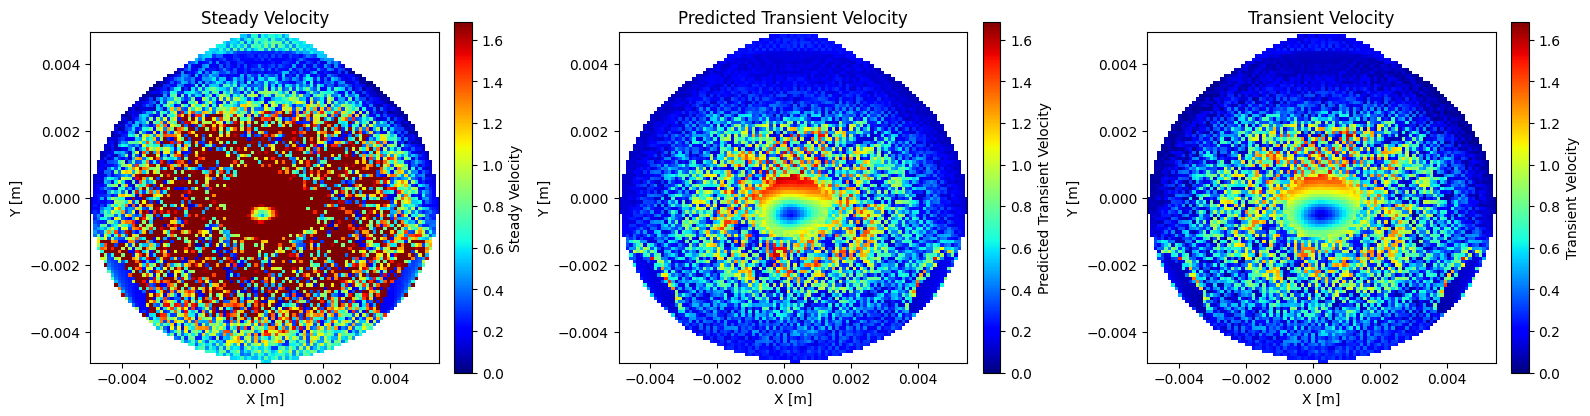

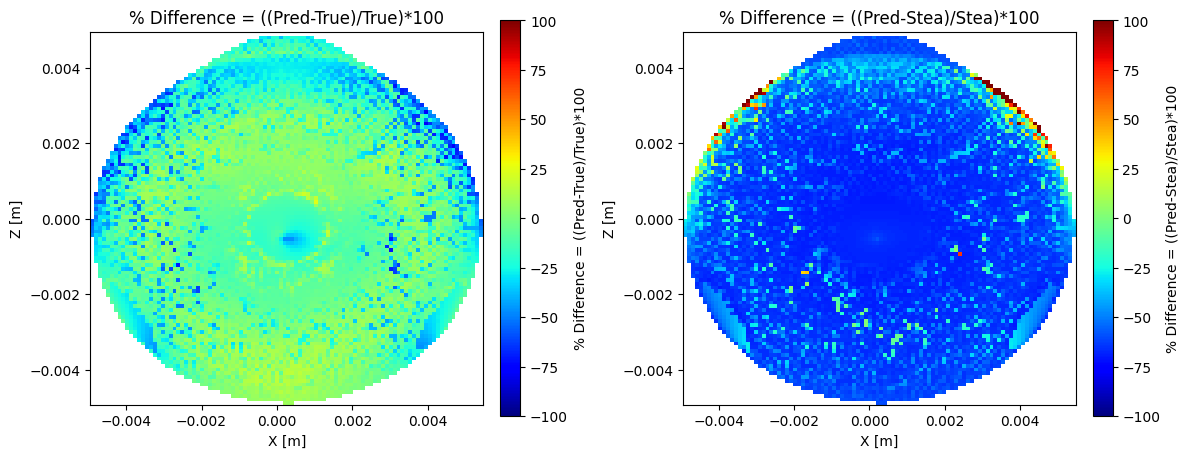

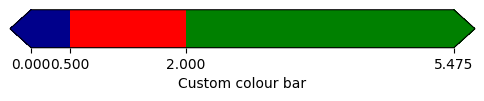

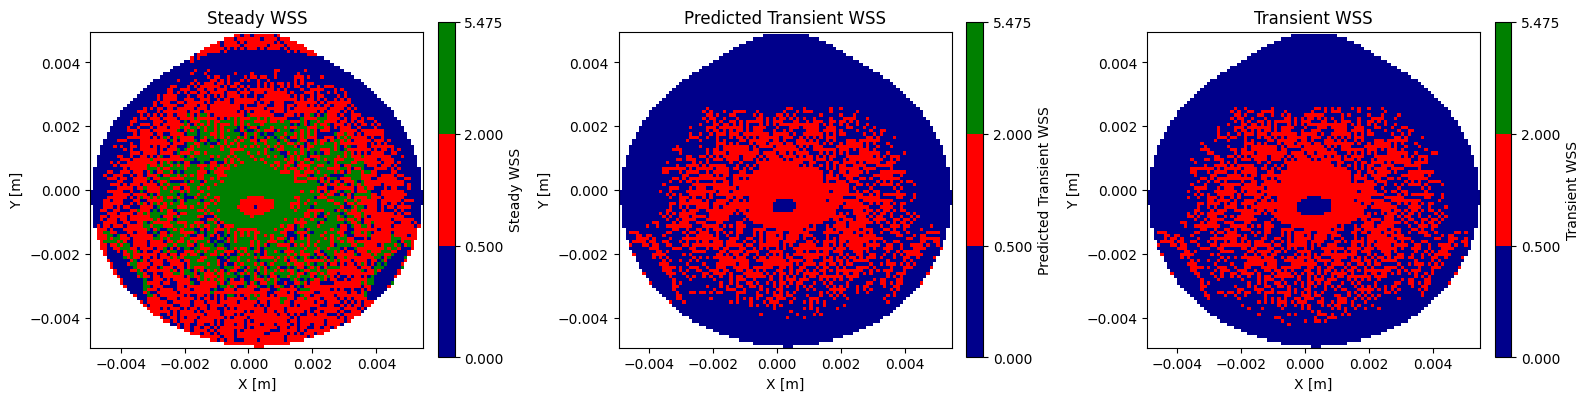

Maximum shear from the prediction is: 1.861626386642456
Maximum shear from the actual is: 1.9
Min shear from the prediction is: 0.07829746603965759
Min shear from the actual is: 0.000913
% is: 2.019663860923361
0.9780575431936975


(13.962073177289454, 58.4232124380492)

In [30]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste7, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste7, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction7)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient7[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction7)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient7[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient7[' Wall Shear [ Pa ]'], Prediction7)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N48**

In [31]:
PredictedTransient8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N48PS.csv')
# Print column names
print(PredictedTransient8.columns)
PredictedTransient8 = PredictedTransient8.fillna(0)
PredictedTransient8 = PredictedTransient8.replace(' null', np.nan)
x = PredictedTransient8[' X [ m ]']
y = PredictedTransient8[' Y [ m ]']
ste_velocity8 = PredictedTransient8[' Wall Shear [ Pa ]']
velocity8 = PredictedTransient8['Transient Prediction 8']
diff_ste8 = PredictedTransient8['Transient Prediction 8'] - PredictedTransient8[' Wall Shear [ Pa ]']
CFDTransient8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N48Tlow\N48TS2.csv')
print(CFDTransient8.columns)
CFDTransient8 = CFDTransient8.fillna(0)
CFDTransient8 = CFDTransient8.replace(' null', np.nan)
x = CFDTransient8 [' X [ m ]']
y = CFDTransient8 [' Y [ m ]']
velocity_truth8 = CFDTransient8 [' Wall Shear [ Pa ]']
diff_vel8 = PredictedTransient8 ['Transient Prediction 8'] - CFDTransient8[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 8'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


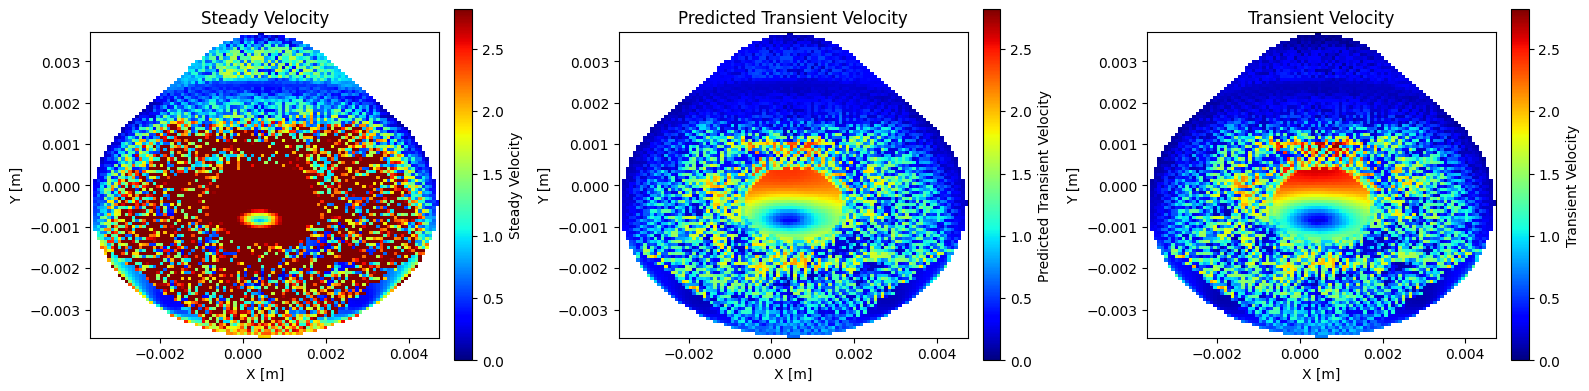

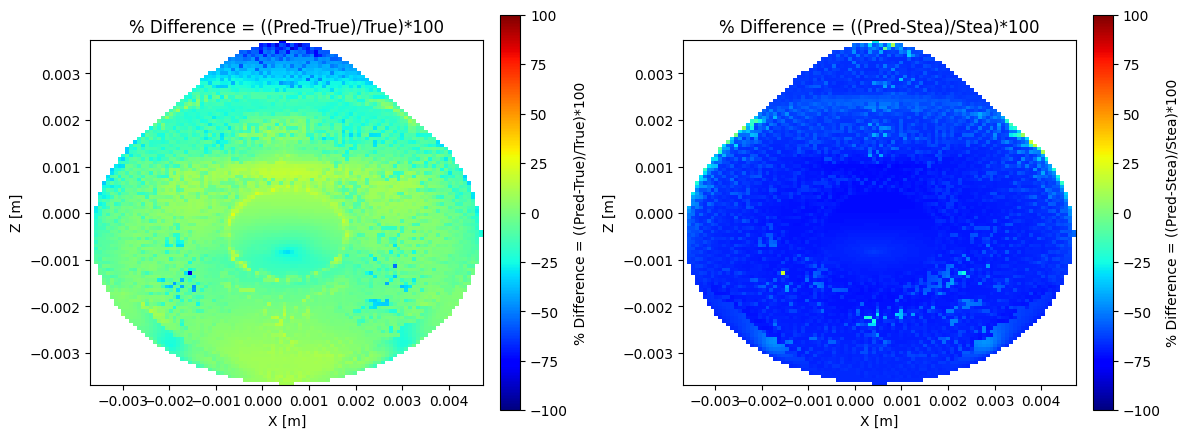

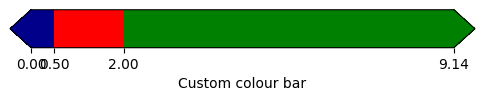

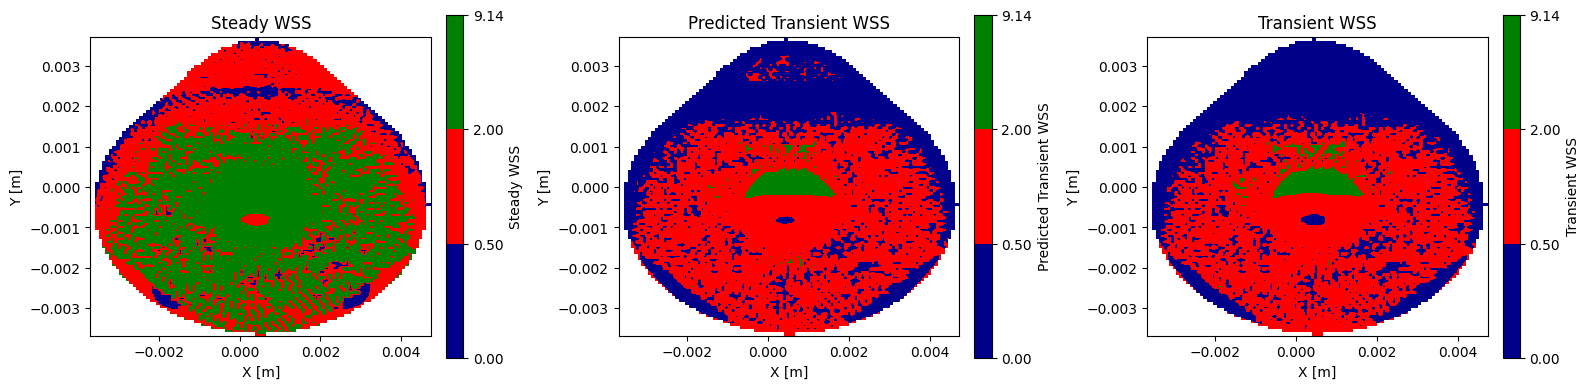

Maximum shear from the prediction is: 2.459993362426758
Maximum shear from the actual is: 2.85
Min shear from the prediction is: 0.08151623606681824
Min shear from the actual is: 0.00368
% is: 13.684443423622536
0.9863259088348484


(9.900153956501727, 65.3729457250385)

In [32]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste8, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste8, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction8)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient8[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction8)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient8[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient8[' Wall Shear [ Pa ]'], Prediction8)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N49**

In [33]:
PredictedTransient9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N49PS.csv')
# Print column names
print(PredictedTransient9.columns)
PredictedTransient9 = PredictedTransient9.fillna(0)
PredictedTransient9 = PredictedTransient9.replace(' null', np.nan)
x = PredictedTransient9[' X [ m ]']
y = PredictedTransient9[' Y [ m ]']
ste_velocity9 = PredictedTransient9[' Wall Shear [ Pa ]']
velocity9 = PredictedTransient9['Transient Prediction 9']
diff_ste9 = PredictedTransient9['Transient Prediction 9'] - PredictedTransient9[' Wall Shear [ Pa ]']
CFDTransient9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N49Tlow\N49TS2.csv')
print(CFDTransient9.columns)
CFDTransient9 = CFDTransient9.fillna(0)
CFDTransient9 = CFDTransient9.replace(' null', np.nan)
x = CFDTransient9 [' X [ m ]']
y = CFDTransient9 [' Y [ m ]']
velocity_truth9 = CFDTransient9 [' Wall Shear [ Pa ]']
diff_vel9 = PredictedTransient9 ['Transient Prediction 9'] - CFDTransient9[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 9'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


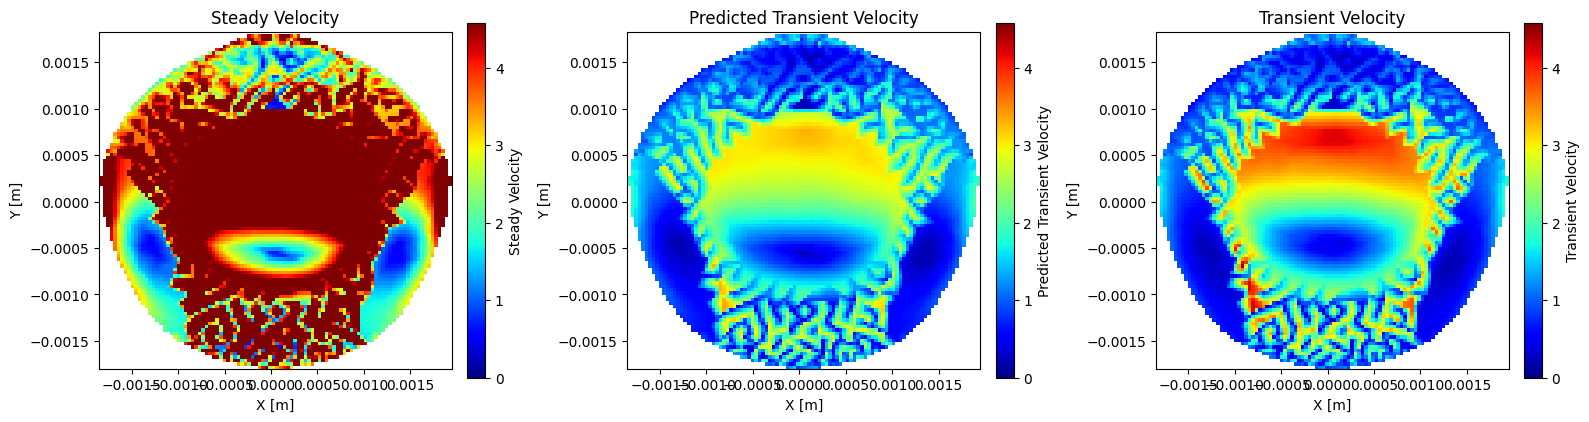

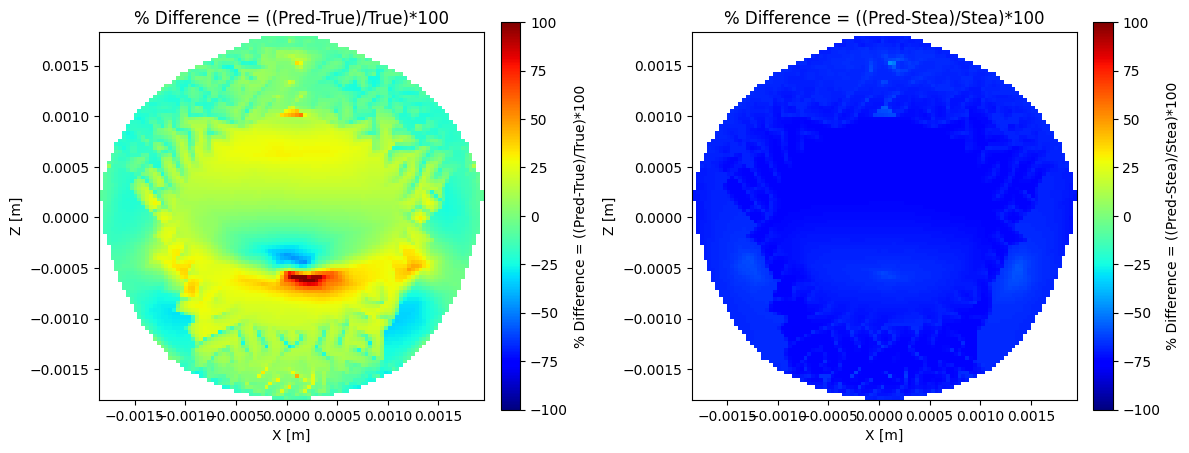

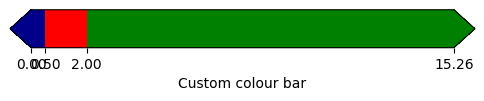

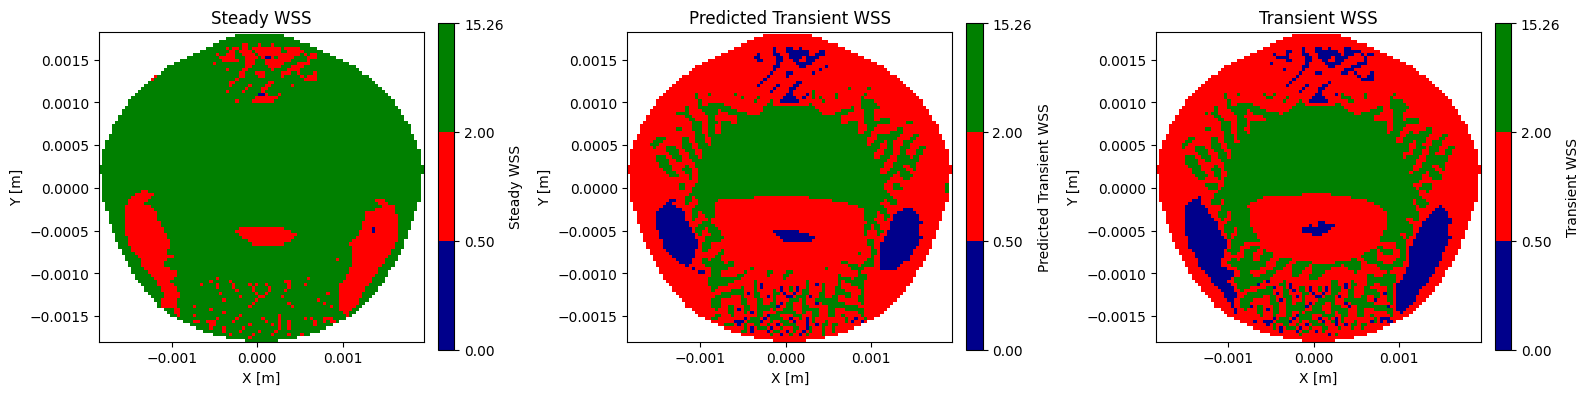

Maximum shear from the prediction is: 3.454888105392456
Maximum shear from the actual is: 4.82
Min shear from the prediction is: 0.11089685559272766
Min shear from the actual is: 0.18
% is: 28.321823539575604
0.9272470178885913


(15.05881154822016, 70.93349629053158)

In [34]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste9, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste9, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction9)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient9[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction9)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient9[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient9[' Wall Shear [ Pa ]'], Prediction9)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4